<a href="https://colab.research.google.com/github/changhoonhahn/gqp_mc/blob/master/nb/training_desi_complexdust_speculator_wavebins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/speculator_fork

/content/drive/My Drive/speculator_fork


In [3]:
import os 
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from speculator import SpectrumPCA
from speculator import Speculator

In [4]:
# read DESI wavelength
wave = np.load('wave_fsps.npy')

In [5]:
n_wave = 0
if n_wave == 0: 
    wave_bin = (wave < 4500) 
elif n_wave == 1: 
    wave_bin = (wave >= 4500) & (wave < 6500) 
elif n_wave == 2: 
    wave_bin = (wave >= 6500) 

In [6]:
n_param = 10
n_pcas  = 30 

In [7]:
# load trained PCA basis object
print('training PCA bases') 
PCABasis = SpectrumPCA(
        n_parameters=n_param,       # number of parameters
        n_wavelengths=np.sum(wave_bin),       # number of wavelength values
        n_pcas=n_pcas,              # number of pca coefficients to include in the basis 
        spectrum_filenames=None,  # list of filenames containing the (un-normalized) log spectra for training the PCA
        parameter_filenames=[], # list of filenames containing the corresponding parameter values
        parameter_selection=None) # pass an optional function that takes in parameter vector(s) and returns True/False for any extra parameter cuts we want to impose on the training sample (eg we may want to restrict the parameter ranges)
PCABasis._load_from_file('DESI_complexdust.0_499.seed0.wave_bin%i.pca%i.hdf5' % (n_wave, n_pcas))

training PCA bases


In [8]:
_training_theta = np.load('DESI_complexdust.0_499.seed0.wave_bin%i.pca%i_parameters.npy' % (n_wave, n_pcas))
_training_pca = np.load('DESI_complexdust.0_499.seed0.wave_bin%i.pca%i_pca.npy'% (n_wave, n_pcas))

In [9]:
N_train = int(2e6)

In [10]:
training_theta = tf.convert_to_tensor(_training_theta.astype(np.float32)[:N_train,:])
training_pca = tf.convert_to_tensor(_training_pca.astype(np.float32)[:N_train,:])

In [11]:
print('training set size = %i' % training_pca.shape[0])

training set size = 2000000


In [17]:
# train Speculator 
speculator = Speculator(
        n_parameters=n_param, # number of model parameters 
        wavelengths=wave, # array of wavelengths
        pca_transform_matrix=PCABasis.pca_transform_matrix,
        parameters_shift=PCABasis.parameters_shift, 
        parameters_scale=PCABasis.parameters_scale, 
        pca_shift=PCABasis.pca_shift, 
        pca_scale=PCABasis.pca_scale, 
        spectrum_shift=PCABasis.spectrum_shift, 
        spectrum_scale=PCABasis.spectrum_scale, 
        n_hidden=[256, 256, 256], # network architecture (list of hidden units per layer)
        restore=False, 
        optimizer=tf.keras.optimizers.Adam()) # optimizer for model training

# cooling schedule
lr = [1e-3, 5e-3, 1e-4, 5e-5, 1e-5, 1e-6]
batch_size = [1000, 5000, 10000, 50000, 100000, 1000000]#int(training_theta.shape[0])]
gradient_accumulation_steps = [1, 1, 1, 1, 1, 1] # split the largest batch size into 10 when computing gradients to avoid memory overflow

# early stopping set up
patience = 40
iepoch = 0 

# save loss function
_floss = os.path.join('DESI_complexdust_model.Ntrain%i.wave_bin%i.pca%i.loss.dat' % (N_train, n_wave, n_pcas))
floss = open(_floss, 'w')
floss.close()

# train using cooling/heating schedule for lr/batch-size
for i in range(len(lr)):
    print('learning rate = ' + str(lr[i]) + ', batch size = ' + str(batch_size[i]))
    # set learning rate
    speculator.optimizer.lr = lr[i]

    n_training = training_theta.shape[0]
    # create iterable dataset (given batch size)
    training_data = tf.data.Dataset.from_tensor_slices((training_theta, training_pca)).shuffle(n_training).batch(batch_size[i])

    # set up training loss
    training_loss   = [np.infty]
    validation_loss = [np.infty]
    best_loss       = np.infty
    early_stopping_counter = 0

    # loop over epochs
    while early_stopping_counter < patience:

        # loop over batches
        for theta, pca in training_data:

            # training step: check whether to accumulate gradients or not (only worth doing this for very large batch sizes)
            if gradient_accumulation_steps[i] == 1:
                loss = speculator.training_step(theta, pca)
            else:
                loss = speculator.training_step_with_accumulated_gradients(theta, pca, accumulation_steps=gradient_accumulation_steps[i])
        
        # compute validation loss at the end of the epoch
        _loss = speculator.compute_loss(training_theta, training_pca).numpy()
        validation_loss.append(_loss)
        iepoch += 1

        if (iepoch % 10) == 0: 
          print('%i: %i \t %f \t %f \n' % (iepoch, batch_size[i], lr[i], _loss))
        floss = open(_floss, 'a')
        floss.write('%i \t %f \t %f \n' % (batch_size[i], lr[i], _loss))
        floss.close()

        # early stopping condition
        if validation_loss[-1] < best_loss:
            best_loss = validation_loss[-1]
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            speculator.update_emulator_parameters()
            speculator.save('_DESI_complexdust_model.Ntrain%i.wave_bin%i.pca%i.log' % (N_train, n_wave, n_pcas))

            attributes = list([
                    list(speculator.W_), 
                    list(speculator.b_), 
                    list(speculator.alphas_), 
                    list(speculator.betas_), 
                    speculator.pca_transform_matrix_,
                    speculator.pca_shift_,
                    speculator.pca_scale_,
                    speculator.spectrum_shift_,
                    speculator.spectrum_scale_,
                    speculator.parameters_shift_, 
                    speculator.parameters_scale_,
                    speculator.wavelengths])

            # save attributes to file 
            f = open('DESI_complexdust_model.Ntrain%i.wave_bin%i.pca%i.log.pkl' % (N_train, n_wave, n_pcas), 'wb')
            pickle.dump(attributes, f)
            f.close()
            print('Validation loss = %s' % str(best_loss))

learning rate = 0.001, batch size = 1000
10: 1000 	 0.001000 	 0.480812 

20: 1000 	 0.001000 	 0.085200 

30: 1000 	 0.001000 	 0.052687 

40: 1000 	 0.001000 	 0.057793 

50: 1000 	 0.001000 	 0.049154 

60: 1000 	 0.001000 	 0.045988 

70: 1000 	 0.001000 	 0.021228 

80: 1000 	 0.001000 	 0.024973 

90: 1000 	 0.001000 	 0.022469 

100: 1000 	 0.001000 	 0.022788 

110: 1000 	 0.001000 	 0.023429 

120: 1000 	 0.001000 	 0.022393 

130: 1000 	 0.001000 	 0.023096 

140: 1000 	 0.001000 	 0.022073 

150: 1000 	 0.001000 	 0.019851 

160: 1000 	 0.001000 	 0.016678 

170: 1000 	 0.001000 	 0.009950 

180: 1000 	 0.001000 	 0.015045 

190: 1000 	 0.001000 	 0.013135 

200: 1000 	 0.001000 	 0.011120 

210: 1000 	 0.001000 	 0.010170 

220: 1000 	 0.001000 	 0.011216 

230: 1000 	 0.001000 	 0.014271 

240: 1000 	 0.001000 	 0.017022 

Validation loss = 0.008159716
learning rate = 0.005, batch size = 5000
250: 5000 	 0.005000 	 0.053873 

260: 5000 	 0.005000 	 0.025864 

270: 5000 	 0

In [21]:
loss = np.loadtxt('DESI_complexdust_model.Ntrain%i.wave_bin%i.pca%i.loss.dat' % (N_train, n_wave, n_pcas))

(0.003, 0.1)

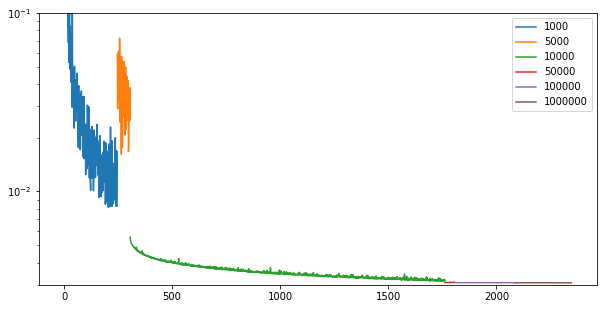

In [33]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for batchsize in np.unique(loss[:,0]):
  isbatch = (loss[:,0] == batchsize)
  sub.plot(np.arange(loss.shape[0])[isbatch], loss[:,2][isbatch], label='%i' % batchsize)
sub.legend(loc='upper right')
sub.set_yscale('log')
sub.set_ylim(3e-3, 0.1)